In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def setup_storage(n_runs, n_slices):

    storage = {
        # Input/Output Image Storage
        'input': torch.zeros(n_runs, n_slices, 96, 96),  # Removed the channel dimension
        'reconstructions': torch.zeros(n_runs, n_slices, 96, 96), # Reconstructed images
        'noise': torch.zeros(n_runs, n_slices, 96, 96),
        'features_raw_embedding': torch.zeros(n_runs, n_slices, 512), 
        'differences': torch.zeros(n_runs, n_slices, 96, 96),     # Difference maps
        'full_raw_embedding': torch.zeros(n_runs, n_slices, 1024),
        'brain_masks': torch.zeros(n_runs, n_slices, 96, 96),     # Brain masks
        
        # # Segmentation and Mask Storage (for completeness)
        # 'segmentations': torch.zeros(n_runs, n_slices, 96, 96),   # Segmentation masks
        
        # UNet Feature Storage
        'features': {
            'down_post_1': torch.zeros(n_runs, n_slices, 128, 96, 96),
            'down_post_4': torch.zeros(n_runs, n_slices, 128, 48, 48),
            'down_post_8': torch.zeros(n_runs, n_slices, 256, 24, 24),
            'middle_post': torch.zeros(n_runs, n_slices, 256, 24, 24),
            'up_post_3': torch.zeros(n_runs, n_slices, 256, 48, 48),
            'up_post_7': torch.zeros(n_runs, n_slices, 256, 96, 96),
            'up_post_final_layer': torch.zeros(n_runs, n_slices, 1, 96, 96)
        },
        
        # Embedding Storage
        'embeddings': {
            'down_post_1_embedding': torch.zeros(n_runs, n_slices, 256),
            'down_post_4_embedding': torch.zeros(n_runs, n_slices, 256),
            'down_post_8_embedding': torch.zeros(n_runs, n_slices, 512),
            'middle_post_embedding': torch.zeros(n_runs, n_slices, 512),
            'up_post_3_embedding': torch.zeros(n_runs, n_slices, 512),
            'up_post_7_embedding': torch.zeros(n_runs, n_slices, 512)
        }
    }
    return storage

In [38]:
# data_path = "/home/rd81/projects/experiment_logs/REPEAT_2_SLICES_100_TIMES_2024-12-05_13-20-52/runs_data_['IXI105-HH-1471_t1.nii.gz']_2_slices.pt"
# data_path = "/home/rd81/projects/experiment_logs/REPEAT_2_SLICES_500_TIMES_2024-12-05_13-21-24/runs_data_['IXI105-HH-1471_t1.nii.gz']_2_slices.pt"
data_path = "/home/rd81/projects/experiment_logs/REPEAT_2_SLICES_700_TIMES_2024-12-05_13-28-33/runs_data_['IXI105-HH-1471_t1.nii.gz']_2_slices.pt"

data = torch.load(data_path)

In [40]:
def check_input_consistency(data):
    """Verify that inputs are identical across runs"""
    input_var = torch.var(data['input'], dim=0)
    print(f"Mean input variance across runs: {input_var.mean():.10f}")

def check_features_embedding_consistency(data):
    """Verify that inputs are identical across runs"""
    input_var = torch.var(data['features_raw_embedding'], dim=0)
    print(f"Mean features_embedding variance across runs: {input_var.mean():.10f}")

def check_full_embedding_consistency(data):
    """Verify that inputs are identical across runs"""
    input_var = torch.var(data['full_raw_embedding'], dim=0)
    print(f"Mean full_embedding variance across runs: {input_var.mean():.10f}")

def check_noise_consistency(data):
    """Verify that inputs are identical across runs"""
    input_var = torch.var(data['noise'], dim=0)
    print(f"Mean noise variance across runs: {input_var.mean():.10f}")

check_input_consistency(data)
check_features_embedding_consistency(data)
check_full_embedding_consistency(data)
check_noise_consistency(data)

Mean input variance across runs: 0.0000000000
Mean features_embedding variance across runs: 0.0000000000
Mean full_embedding variance across runs: 0.0000000000
Mean noise variance across runs: 0.3442469835


In [41]:
def check_input_consistency_per_slice(data):
    """Verify that inputs are identical across runs, reporting per slice"""
    # Split by slice first
    slice0_runs = data['input'][:, 0]  # shape: (100, 96, 96)
    slice1_runs = data['input'][:, 1]  # shape: (100, 96, 96)
    
    # Calculate variance across runs for each slice
    slice0_var = torch.var(slice0_runs, dim=0)  # shape: (96, 96)
    slice1_var = torch.var(slice1_runs, dim=0)  # shape: (96, 96)
    
    # Get mean variance for each slice
    mean_var_slice0 = slice0_var.mean()
    mean_var_slice1 = slice1_var.mean()
    
    print(f"Mean variance for slice 0: {mean_var_slice0:.10f}")
    print(f"Mean variance for slice 1: {mean_var_slice1:.10f}")
    
    return mean_var_slice0, mean_var_slice1


def check_noise_consistency_per_slice(data):
    """Verify that inputs are identical across runs, reporting per slice"""
    # Split by slice first
    slice0_runs = data['noise'][:, 0]  # shape: (100, 96, 96)
    slice1_runs = data['noise'][:, 1]  # shape: (100, 96, 96)
    
    # Calculate variance across runs for each slice
    slice0_var = torch.var(slice0_runs, dim=0)  # shape: (96, 96)
    slice1_var = torch.var(slice1_runs, dim=0)  # shape: (96, 96)
    
    # Get mean variance for each slice
    mean_var_slice0 = slice0_var.mean()
    mean_var_slice1 = slice1_var.mean()
    
    print(f"Mean variance for slice 0: {mean_var_slice0:.10f}")
    print(f"Mean variance for slice 1: {mean_var_slice1:.10f}")
    
    return mean_var_slice0, mean_var_slice1

check_input_consistency_per_slice(data)
check_noise_consistency_per_slice(data)

Mean variance for slice 0: 0.0000000000
Mean variance for slice 1: 0.0000000000
Mean variance for slice 0: 0.3442470133
Mean variance for slice 1: 0.3442470133


(tensor(0.3442), tensor(0.3442))

In [42]:
def analyze_reconstruction_consistency(data):
    """Analyze how reconstructions vary across runs"""
    # Calculate variance across runs for each pixel
    reco_var = torch.var(data['reconstructions'], dim=0)
    
    # Calculate coefficient of variation (CV = std/mean)
    reco_std = torch.std(data['reconstructions'], dim=0)
    reco_mean = torch.mean(data['reconstructions'], dim=0)
    cv = torch.where(reco_mean != 0, reco_std / reco_mean, torch.zeros_like(reco_std))
    
    metrics = {
        'mean_variance': reco_var.mean().item(),
        'max_variance': reco_var.max().item(),
        'mean_cv': cv.mean().item(),
        # 'variance_maps': reco_var,
        # 'cv_maps': cv
    }
    
    print("\nReconstruction Consistency Metrics:")
    print(f"Mean variance: {metrics['mean_variance']:.6f}")
    print(f"Max variance: {metrics['max_variance']:.6f}")
    print(f"Mean CV: {metrics['mean_cv']:.6f}")
    
    return metrics

analyze_reconstruction_consistency(data)


Reconstruction Consistency Metrics:
Mean variance: 0.001793
Max variance: 0.018301
Mean CV: 0.270093


{'mean_variance': 0.0017927015433087945,
 'max_variance': 0.018300672993063927,
 'mean_cv': 0.2700928747653961}

In [43]:
def analyze_reconstruction_consistency_per_slice(data):
    """Analyze how reconstructions vary across runs, separately for each slice"""
    # Split by slice first
    slice0_runs = data['reconstructions'][:, 0]  # shape: (100, 96, 96)
    slice1_runs = data['reconstructions'][:, 1]  # shape: (100, 96, 96)
    
    # Calculate metrics for each slice
    metrics = {}
    
    for slice_idx, slice_runs in enumerate([slice0_runs, slice1_runs]):
        # Calculate variance across runs for this slice
        slice_var = torch.var(slice_runs, dim=0)  # shape: (96, 96)
        
        # Calculate CV for this slice
        slice_std = torch.std(slice_runs, dim=0)
        slice_mean = torch.mean(slice_runs, dim=0)
        slice_cv = torch.where(slice_mean != 0, 
                             slice_std / slice_mean, 
                             torch.zeros_like(slice_std))
        
        metrics[f'slice_{slice_idx}'] = {
            'mean_variance': slice_var.mean().item(),
            'max_variance': slice_var.max().item(),
            'mean_cv': slice_cv.mean().item(),
            'variance_map': slice_var,
            'cv_map': slice_cv
        }
        
        print(f"\nReconstruction Consistency Metrics for Slice {slice_idx}:")
        print(f"Mean variance: {metrics[f'slice_{slice_idx}']['mean_variance']:.6f}")
        print(f"Max variance: {metrics[f'slice_{slice_idx}']['max_variance']:.6f}")
        print(f"Mean CV: {metrics[f'slice_{slice_idx}']['mean_cv']:.6f}")
    
    # return metrics

analyze_reconstruction_consistency_per_slice(data)


Reconstruction Consistency Metrics for Slice 0:
Mean variance: 0.001882
Max variance: 0.018301
Mean CV: 0.278184

Reconstruction Consistency Metrics for Slice 1:
Mean variance: 0.001704
Max variance: 0.012956
Mean CV: 0.262001



Metrics for Slice 0 (within brain mask only):
Mean variance: 0.001754
Max variance: 0.018301
Mean CV: 0.039023

Metrics for Slice 1 (within brain mask only):
Mean variance: 0.001609
Max variance: 0.012956
Mean CV: 0.037912


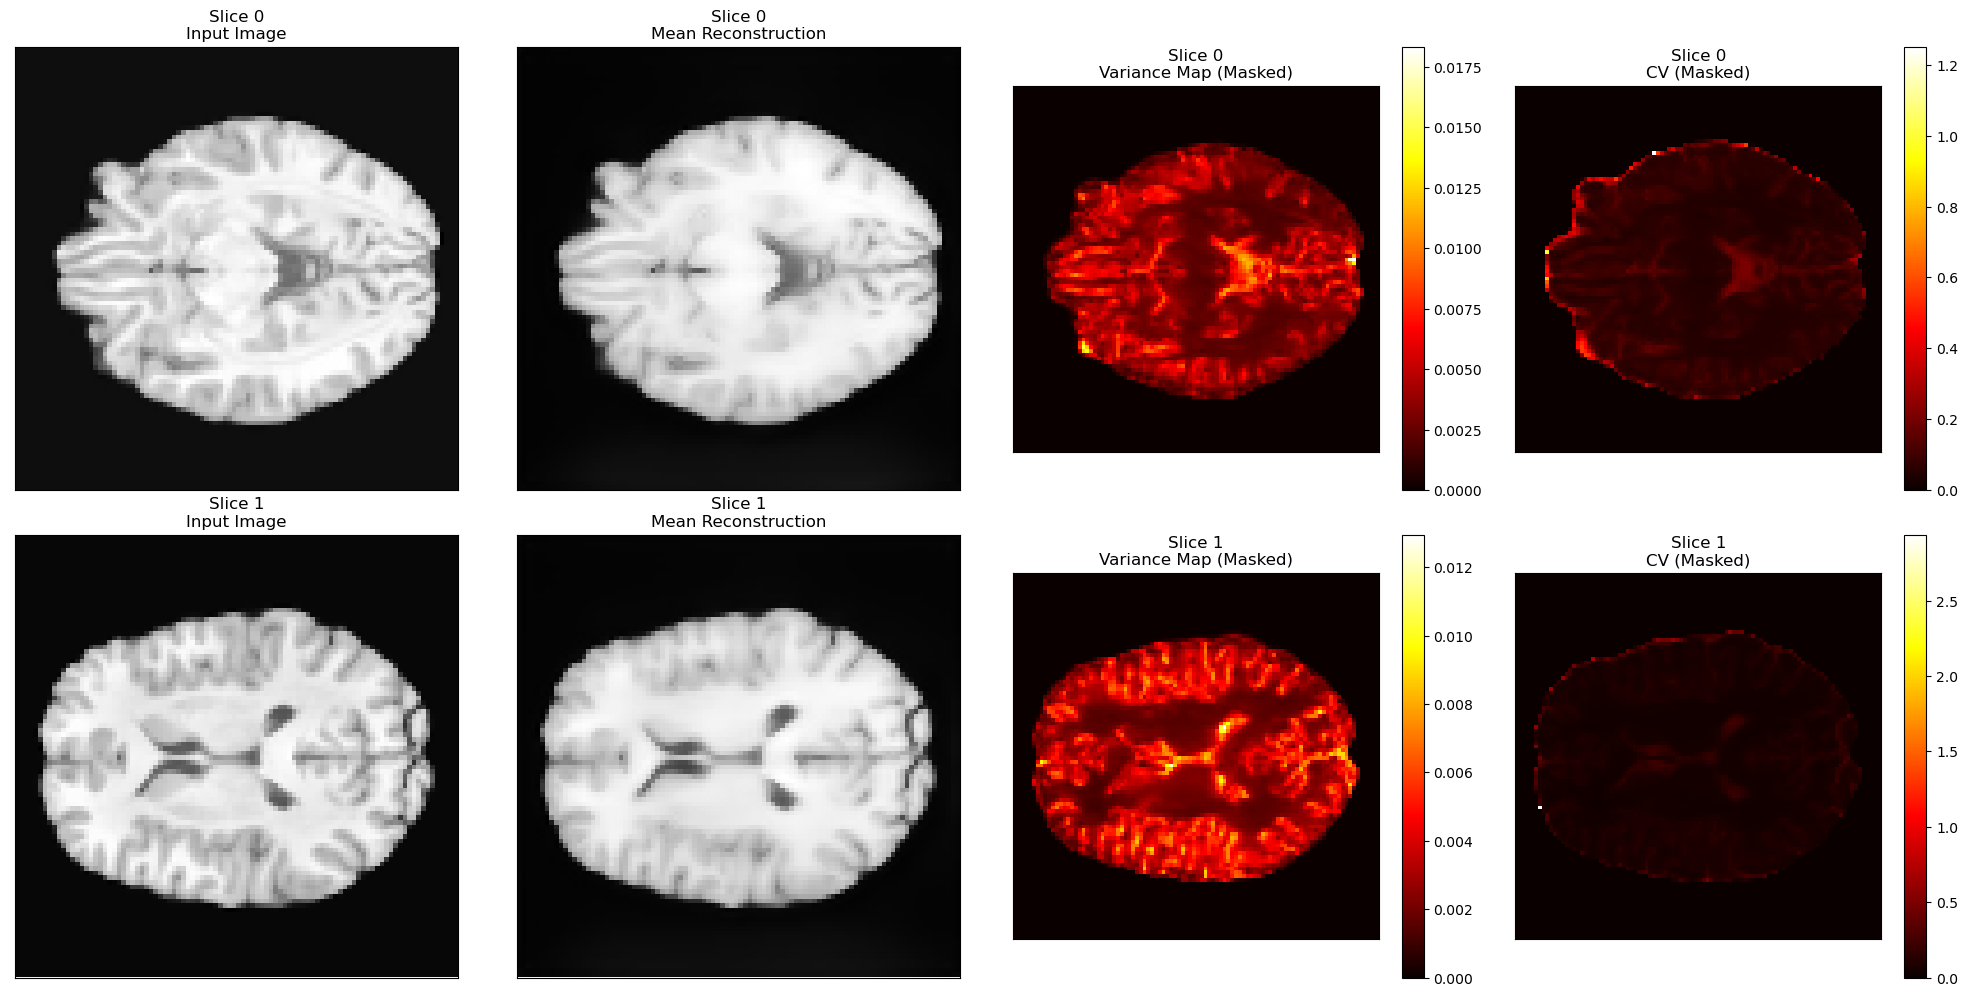

{'slice_0': {'mean_variance': 0.001753828371874988,
  'max_variance': 0.018300672993063927,
  'mean_cv': 0.039022643119096756},
 'slice_1': {'mean_variance': 0.001608764287084341,
  'max_variance': 0.012955700978636742,
  'mean_cv': 0.037911608815193176}}

In [44]:
def analyze_and_visualize_reconstruction_consistency(data):
    """Analyze and visualize reconstruction variation across runs for each slice"""
    metrics = {}
    
    # Increased figure width to accommodate the new column
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    for slice_idx in [0, 1]:
        # Get slice data
        slice_runs = data['reconstructions'][:, slice_idx]  # (n_runs, 96, 96)
        brain_mask = data['brain_masks'][0, slice_idx]  # Get mask for this slice
        input_slice = data['input'][0, slice_idx]  # Get the input image
        
        # Calculate statistics
        slice_var = torch.var(slice_runs, dim=0)
        slice_std = torch.std(slice_runs, dim=0)
        slice_mean = torch.mean(slice_runs, dim=0)
        
        # Calculate CV only within brain mask
        slice_cv = torch.where(slice_mean != 0, 
                             slice_std / torch.abs(slice_mean), 
                             torch.zeros_like(slice_std))
        slice_cv = slice_cv * brain_mask  # Apply mask
        
        metrics[f'slice_{slice_idx}'] = {
            'mean_variance': (slice_var * brain_mask).mean().item(),
            'max_variance': (slice_var * brain_mask).max().item(),
            'mean_cv': (slice_cv * brain_mask).mean().item(),
        }
        
        # Plot input image
        axes[slice_idx, 0].imshow(input_slice.cpu(), cmap='gray')
        axes[slice_idx, 0].set_title(f'Slice {slice_idx}\nInput Image')
        
        # Plot mean reconstruction
        axes[slice_idx, 1].imshow(slice_mean.cpu(), cmap='gray')
        axes[slice_idx, 1].set_title(f'Slice {slice_idx}\nMean Reconstruction')
        
        # Plot masked variance map
        var_img = axes[slice_idx, 2].imshow((slice_var * brain_mask).cpu(), cmap='hot')
        axes[slice_idx, 2].set_title(f'Slice {slice_idx}\nVariance Map (Masked)')
        plt.colorbar(var_img, ax=axes[slice_idx, 2])
        
        # Plot masked CV map
        cv_img = axes[slice_idx, 3].imshow((slice_cv * brain_mask).cpu(), cmap='hot')
        axes[slice_idx, 3].set_title(f'Slice {slice_idx}\nCV (Masked)')
        plt.colorbar(cv_img, ax=axes[slice_idx, 3])
        
        # Print metrics
        print(f"\nMetrics for Slice {slice_idx} (within brain mask only):")
        print(f"Mean variance: {metrics[f'slice_{slice_idx}']['mean_variance']:.6f}")
        print(f"Max variance: {metrics[f'slice_{slice_idx}']['max_variance']:.6f}")
        print(f"Mean CV: {metrics[f'slice_{slice_idx}']['mean_cv']:.6f}")
    
    # Remove axes ticks
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    return metrics
analyze_and_visualize_reconstruction_consistency(data)

In [45]:
def analyze_feature_consistency(data):
    """Analyze consistency of UNet feature maps across runs"""
    feature_metrics = {}
    
    for layer_name, feature_maps in data['features'].items():
        # Calculate variance across runs for each feature position
        variance = torch.var(feature_maps, dim=0)
        
        # Calculate mean variance for each feature channel
        channel_variance = variance.mean(dim=(1, 2))  # Average over spatial dimensions
        
        metrics = {
            'mean_variance': variance.mean().item(),
            'max_variance': variance.max().item(),
            'channel_variances': channel_variance,
            'variance_maps': variance
        }
        
        feature_metrics[layer_name] = metrics
        
        print(f"\n{layer_name} Feature Consistency:")
        print(f"Mean variance: {metrics['mean_variance']:.6f}")
        print(f"Max variance: {metrics['max_variance']:.6f}")
    
    # return feature_metrics
analyze_feature_consistency(data)


down_post_1 Feature Consistency:
Mean variance: 0.062342
Max variance: 8.589265

down_post_4 Feature Consistency:
Mean variance: 0.585208
Max variance: 74.759613

down_post_8 Feature Consistency:
Mean variance: 1.356324
Max variance: 28.909637

middle_post Feature Consistency:
Mean variance: 3.953439
Max variance: 51.885921

up_post_3 Feature Consistency:
Mean variance: 3.504638
Max variance: 83.743217

up_post_7 Feature Consistency:
Mean variance: 0.968570
Max variance: 22.730587

up_post_final_layer Feature Consistency:
Mean variance: 0.007171
Max variance: 0.073207



=== down_post_1 ===
Feature map shape: torch.Size([700, 2, 128, 96, 96]) [128 channels, 96×96]

Slice 0:
Mean variance: 0.061421
Max variance: 6.707421

Top variable channels:
Channel 123: 0.376169
Channel 81: 0.244189
Channel 28: 0.202046
Channel 121: 0.158200
Channel 73: 0.158107

Spatial variance - Mean: 0.061421, Max: 0.652886


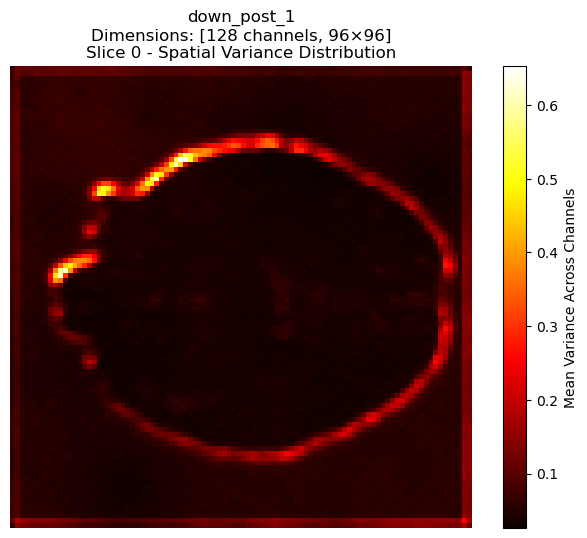


Slice 1:
Mean variance: 0.063263
Max variance: 8.589265

Top variable channels:
Channel 123: 0.391018
Channel 81: 0.238982
Channel 28: 0.206125
Channel 121: 0.168035
Channel 73: 0.158660

Spatial variance - Mean: 0.063263, Max: 0.790515


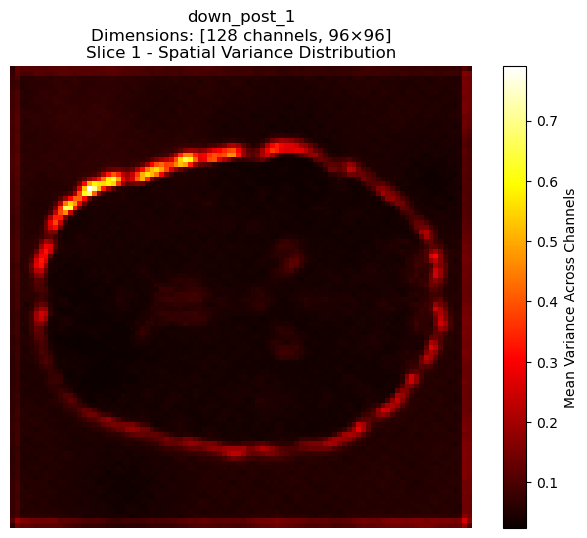

--------------------------------------------------

=== down_post_4 ===
Feature map shape: torch.Size([700, 2, 128, 48, 48]) [128 channels, 48×48]

Slice 0:
Mean variance: 0.572440
Max variance: 74.759613

Top variable channels:
Channel 24: 2.710023
Channel 67: 2.537093
Channel 121: 2.012886
Channel 55: 1.270088
Channel 127: 1.243508

Spatial variance - Mean: 0.572440, Max: 4.575499


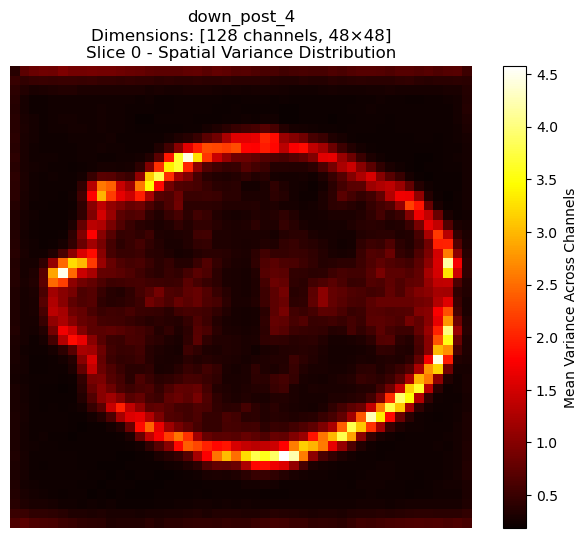


Slice 1:
Mean variance: 0.597976
Max variance: 69.144905

Top variable channels:
Channel 24: 2.948870
Channel 67: 2.686357
Channel 121: 2.278240
Channel 95: 1.341545
Channel 127: 1.340503

Spatial variance - Mean: 0.597976, Max: 4.578262


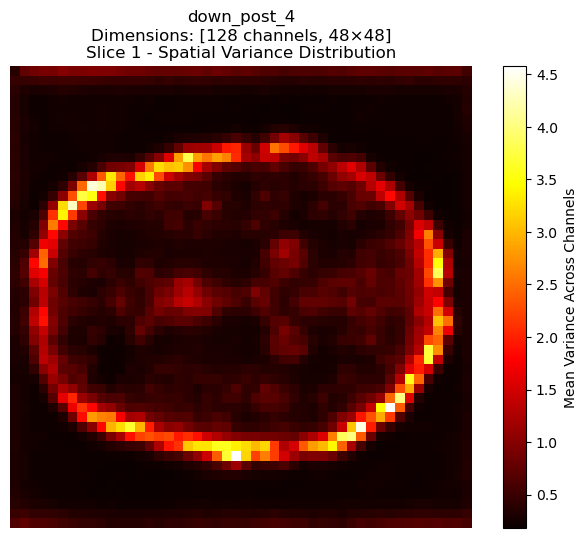

--------------------------------------------------

=== down_post_8 ===
Feature map shape: torch.Size([700, 2, 256, 24, 24]) [256 channels, 24×24]

Slice 0:
Mean variance: 1.280033
Max variance: 24.797241

Top variable channels:
Channel 103: 4.705561
Channel 116: 4.076864
Channel 93: 3.795851
Channel 4: 3.584373
Channel 65: 3.465327

Spatial variance - Mean: 1.280033, Max: 2.853134


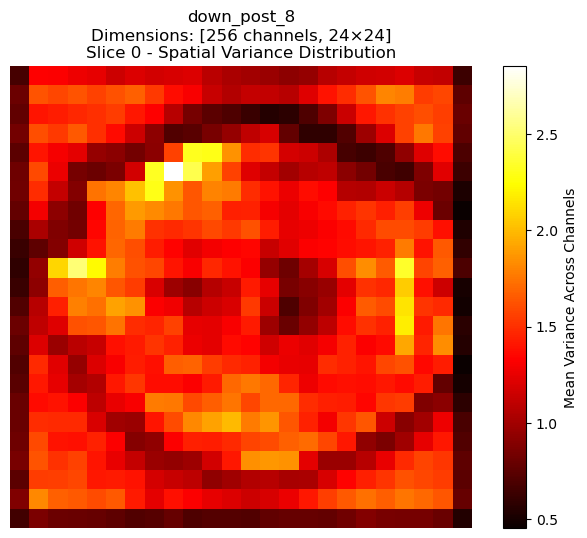


Slice 1:
Mean variance: 1.432616
Max variance: 28.909637

Top variable channels:
Channel 103: 5.121221
Channel 116: 4.407433
Channel 4: 4.231965
Channel 93: 3.870062
Channel 65: 3.848313

Spatial variance - Mean: 1.432616, Max: 3.630194


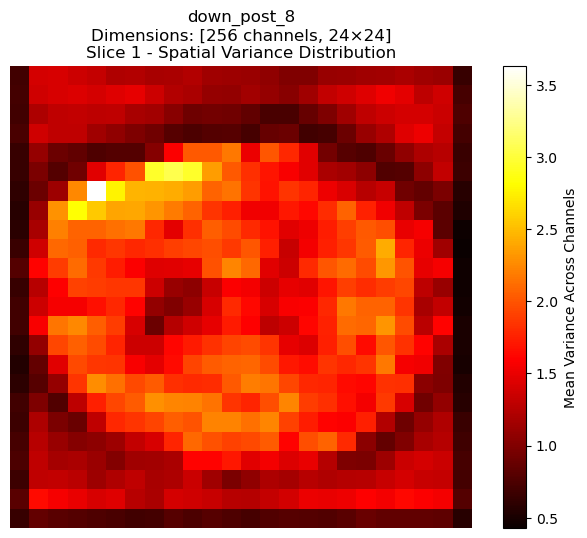

--------------------------------------------------

=== middle_post ===
Feature map shape: torch.Size([700, 2, 256, 24, 24]) [256 channels, 24×24]

Slice 0:
Mean variance: 3.866738
Max variance: 43.090481

Top variable channels:
Channel 26: 10.516190
Channel 103: 8.869073
Channel 246: 8.782330
Channel 151: 8.576520
Channel 108: 8.530248

Spatial variance - Mean: 3.866738, Max: 9.852626


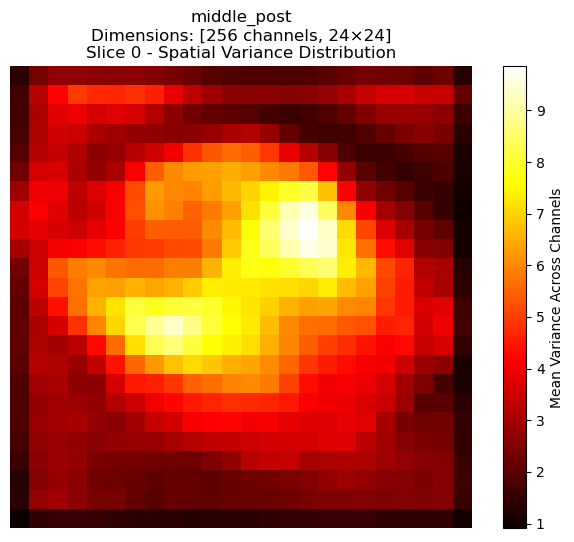


Slice 1:
Mean variance: 4.040140
Max variance: 51.885921

Top variable channels:
Channel 26: 11.562670
Channel 75: 9.316735
Channel 103: 9.127044
Channel 246: 9.096437
Channel 228: 8.869958

Spatial variance - Mean: 4.040140, Max: 10.763511


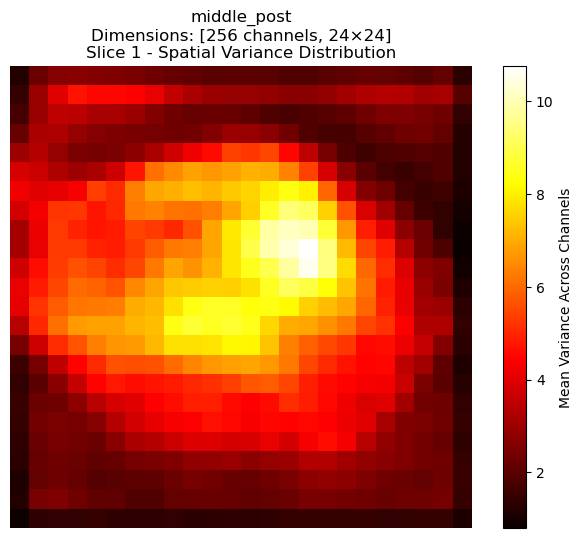

--------------------------------------------------

=== up_post_3 ===
Feature map shape: torch.Size([700, 2, 256, 48, 48]) [256 channels, 48×48]

Slice 0:
Mean variance: 3.391410
Max variance: 83.743217

Top variable channels:
Channel 248: 17.035225
Channel 252: 15.971261
Channel 169: 15.185499
Channel 90: 13.843117
Channel 22: 10.725695

Spatial variance - Mean: 3.391410, Max: 9.179891


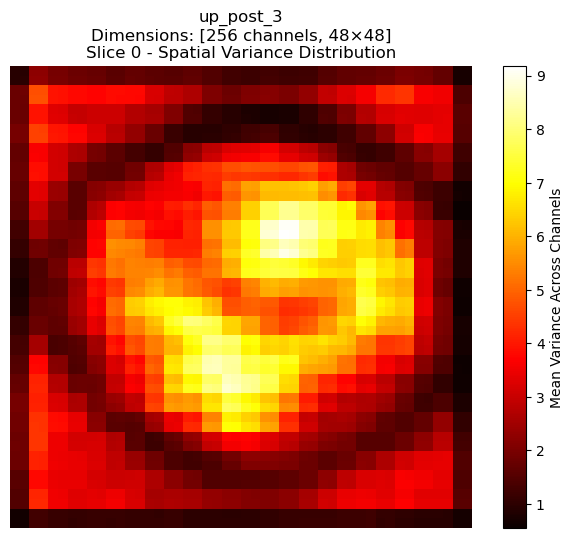


Slice 1:
Mean variance: 3.617866
Max variance: 81.118622

Top variable channels:
Channel 252: 17.786404
Channel 248: 16.687233
Channel 169: 15.786366
Channel 90: 13.915988
Channel 22: 11.553659

Spatial variance - Mean: 3.617866, Max: 10.476114


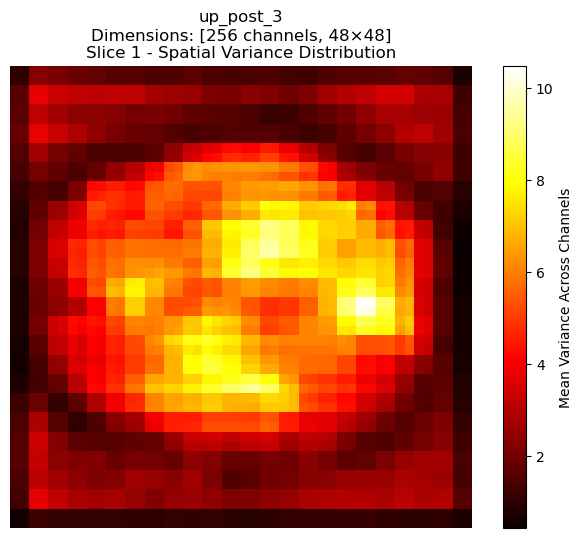

--------------------------------------------------

=== up_post_7 ===
Feature map shape: torch.Size([700, 2, 256, 96, 96]) [256 channels, 96×96]

Slice 0:
Mean variance: 0.959412
Max variance: 21.353836

Top variable channels:
Channel 24: 3.163886
Channel 54: 2.782434
Channel 11: 2.779965
Channel 181: 2.756557
Channel 112: 2.671598

Spatial variance - Mean: 0.959412, Max: 3.242738


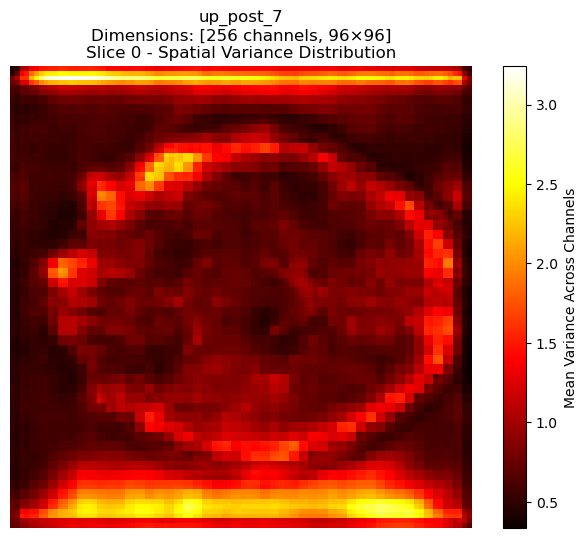


Slice 1:
Mean variance: 0.977727
Max variance: 22.730587

Top variable channels:
Channel 24: 2.914699
Channel 54: 2.867259
Channel 181: 2.828633
Channel 11: 2.826501
Channel 130: 2.700261

Spatial variance - Mean: 0.977727, Max: 3.491904


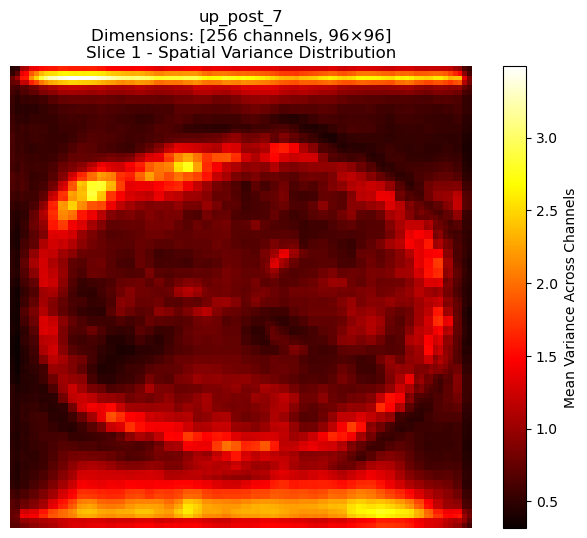

--------------------------------------------------

=== up_post_final_layer ===
Feature map shape: torch.Size([700, 2, 1, 96, 96]) [1 channels, 96×96]

Slice 0:
Mean variance: 0.007527
Max variance: 0.073207

Top variable channels:
Channel 0: 0.007527

Spatial variance - Mean: 0.007527, Max: 0.073207


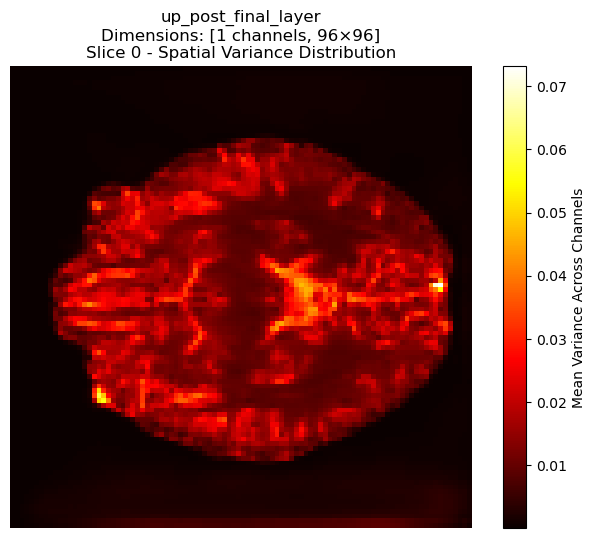


Slice 1:
Mean variance: 0.006815
Max variance: 0.051826

Top variable channels:
Channel 0: 0.006815

Spatial variance - Mean: 0.006815, Max: 0.051826


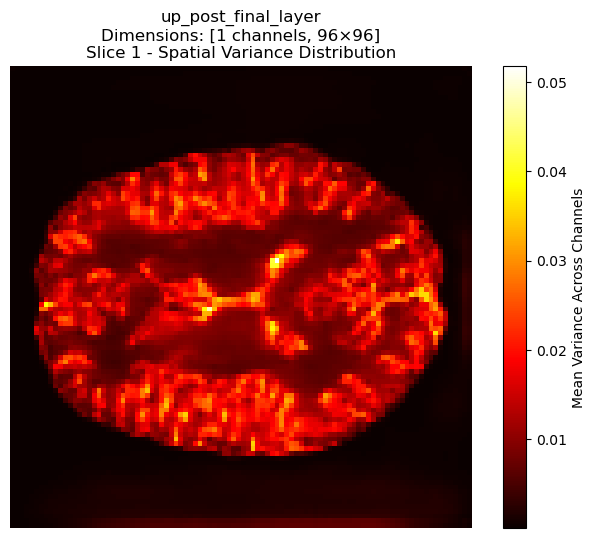

--------------------------------------------------


In [46]:
def analyze_feature_maps(data):
    """
    Analyze UNet feature maps variation across runs, with dimensionality information
    """
    for layer_name, feature_maps in data['features'].items():
        print(f"\n=== {layer_name} ===")
        shape_str = f"[{feature_maps.shape[2]} channels, {feature_maps.shape[3]}×{feature_maps.shape[4]}]"
        print(f"Feature map shape: {feature_maps.shape} {shape_str}")
        
        # Calculate variance across runs
        variance = torch.var(feature_maps, dim=0)  # [n_slices, channels, H, W]
        
        # Per-slice statistics
        for slice_idx in range(variance.shape[0]):
            print(f"\nSlice {slice_idx}:")
            
            # 1. Overall variance statistics
            slice_variance = variance[slice_idx]  # [channels, H, W]
            mean_var = slice_variance.mean().item()
            max_var = slice_variance.max().item()
            print(f"Mean variance: {mean_var:.6f}")
            print(f"Max variance: {max_var:.6f}")
            
            # 2. Channel-wise statistics
            channel_variance = slice_variance.mean(dim=(1, 2))  # [channels]
            top_k = min(5, len(channel_variance))
            top_channels = torch.topk(channel_variance, k=top_k)
            
            print("\nTop variable channels:")
            for idx, (channel_idx, var_value) in enumerate(zip(top_channels.indices, top_channels.values)):
                print(f"Channel {channel_idx.item()}: {var_value.item():.6f}")
            
            # 3. Spatial statistics
            spatial_var = slice_variance.mean(dim=0)  # [H, W]
            print(f"\nSpatial variance - Mean: {spatial_var.mean().item():.6f}, Max: {spatial_var.max().item():.6f}")
            
            # Visualize the spatial variance map with dimensionality info
            plt.figure(figsize=(8, 6))
            plt.imshow(spatial_var.cpu(), cmap='hot')
            plt.colorbar(label='Mean Variance Across Channels')
            title = (f'{layer_name}\n'
                    f'Dimensions: {shape_str}\n'
                    f'Slice {slice_idx} - Spatial Variance Distribution')
            plt.title(title)
            plt.axis('off')
            plt.show()
            
        print("-" * 50)

# Run the analysis
analyze_feature_maps(data)

Let me break down what these maps are showing in the context of your diffusion model's consistency:

1. **Variance Map (3rd column)**:
- This shows the absolute variance in pixel values across all 100 runs at each spatial location
- Brighter areas (yellower/whiter) indicate locations where the reconstructed pixel values varied more across runs
- Darker areas (more black/red) indicate locations where the reconstructions were more consistent
- The fact that there's more variance in the internal structures and less at the edges suggests that the model is more "uncertain" or "variable" in how it reconstructs complex internal brain structures
- This makes intuitive sense as these areas have more complex features and tissue interfaces

2. **CV (Coefficient of Variation) Map (4th column)**:
- CV = Standard Deviation / Mean
- This shows the relative variance normalized by the mean intensity at each point
- The bright rim around the brain edge is particularly interesting because it shows that while these areas might not have high absolute variance, they have high variance relative to their mean intensity
- This suggests that edge regions, while perhaps having smaller absolute variations, have more significant variations relative to their typical values
- This could indicate that the model is less confident about exact boundary placement, even though it's generally consistent about the overall brain shape

The key difference between these maps is:
- Variance Map shows where reconstructions vary the most in absolute terms
- CV Map shows where reconstructions vary the most relative to the expected intensity at that location

This comprehensive view reveals that your diffusion model:
1. Is most consistent in reconstructing large, uniform regions
2. Shows more variability in reconstructing detailed internal structures
3. Has particular uncertainty about exact boundary placements, even though it maintains overall brain shape
4. Exhibits different patterns of absolute vs. relative consistency across the image

In [47]:
def analyze_embedding_consistency(data):
    """Analyze consistency of embeddings across runs"""
    embedding_metrics = {}
    
    for emb_name, embeddings in data['embeddings'].items():
        # Calculate variance across runs for each embedding dimension
        variance = torch.var(embeddings, dim=0)
        
        metrics = {
            'mean_variance': variance.mean().item(),
            'max_variance': variance.max().item(),
            'dimension_variances': variance,
        }
        
        embedding_metrics[emb_name] = metrics
        
        print(f"\n{emb_name} Embedding Consistency:")
        print(f"Mean variance: {metrics['mean_variance']:.6f}")
        print(f"Max variance: {metrics['max_variance']:.6f}")
    
    # return embedding_metrics

analyze_embedding_consistency(data)


down_post_1_embedding Embedding Consistency:
Mean variance: 0.000000
Max variance: 0.000000

down_post_4_embedding Embedding Consistency:
Mean variance: 0.000000
Max variance: 0.000000

down_post_8_embedding Embedding Consistency:
Mean variance: 0.000000
Max variance: 0.000000

middle_post_embedding Embedding Consistency:
Mean variance: 0.000000
Max variance: 0.000000

up_post_3_embedding Embedding Consistency:
Mean variance: 0.000000
Max variance: 0.000000

up_post_7_embedding Embedding Consistency:
Mean variance: 0.000000
Max variance: 0.000000


In [48]:
def plot_variance_maps(metrics, slice_idx=0):
    """Plot variance maps for reconstructions and feature maps"""
    # Plot reconstruction variance
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.imshow(metrics['reconstruction']['variance_maps'][slice_idx], cmap='hot')
    plt.colorbar()
    plt.title('Reconstruction Variance Map')
    
    plt.subplot(122)
    plt.imshow(metrics['reconstruction']['cv_maps'][slice_idx], cmap='hot')
    plt.colorbar()
    plt.title('Reconstruction CV Map')
    
    plt.tight_layout()
    plt.show()
    
    # Plot feature map variances
    for layer_name, layer_metrics in metrics['features'].items():
        variance_maps = layer_metrics['variance_maps']
        
        # Plot first few channels
        n_channels = min(4, variance_maps.shape[0])
        plt.figure(figsize=(15, 3))
        
        for i in range(n_channels):
            plt.subplot(1, n_channels, i+1)
            plt.imshow(variance_maps[i, slice_idx], cmap='hot')
            plt.colorbar()
            plt.title(f'{layer_name}\nChannel {i}')
        
        plt.tight_layout()
        plt.show()
plot_variance_maps(metrics, slice_idx=0)

NameError: name 'metrics' is not defined

Mean input variance across runs: 0.0000000000

Reconstruction Consistency Metrics:
Mean variance: 0.001793
Max variance: 0.018301
Mean CV: 0.270093

down_post_1 Feature Consistency:
Mean variance: 0.062342
Max variance: 8.589265

down_post_4 Feature Consistency:
Mean variance: 0.585208
Max variance: 74.759613

down_post_8 Feature Consistency:
Mean variance: 1.356324
Max variance: 28.909637

middle_post Feature Consistency:
Mean variance: 3.953439
Max variance: 51.885921

up_post_3 Feature Consistency:
Mean variance: 3.504638
Max variance: 83.743217

up_post_7 Feature Consistency:
Mean variance: 0.968570
Max variance: 22.730587

up_post_final_layer Feature Consistency:
Mean variance: 0.007171
Max variance: 0.073207

down_post_1_embedding Embedding Consistency:
Mean variance: 0.000000
Max variance: 0.000000

down_post_4_embedding Embedding Consistency:
Mean variance: 0.000000
Max variance: 0.000000

down_post_8_embedding Embedding Consistency:
Mean variance: 0.000000
Max variance: 0.0000

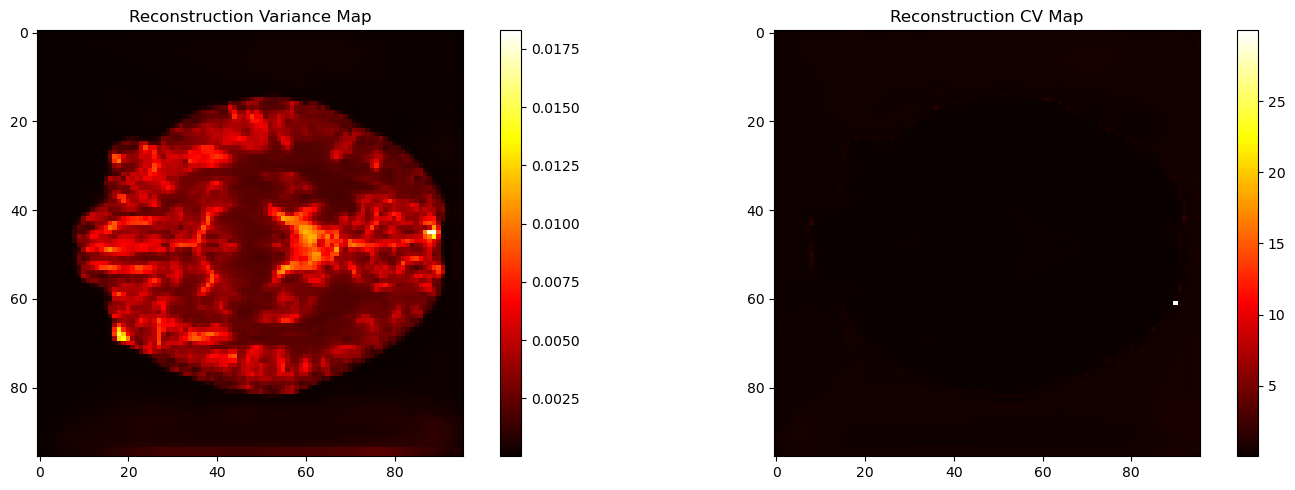

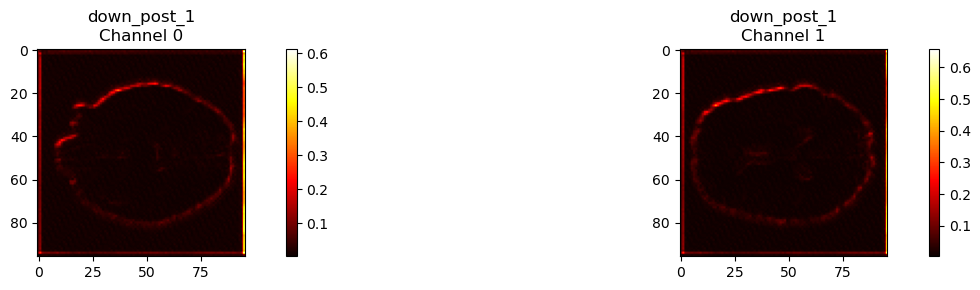

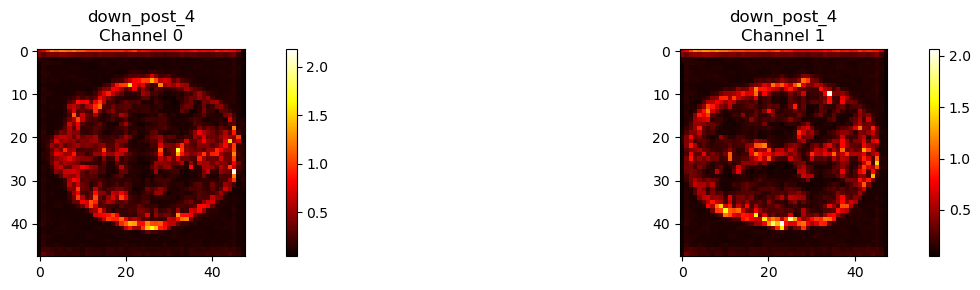

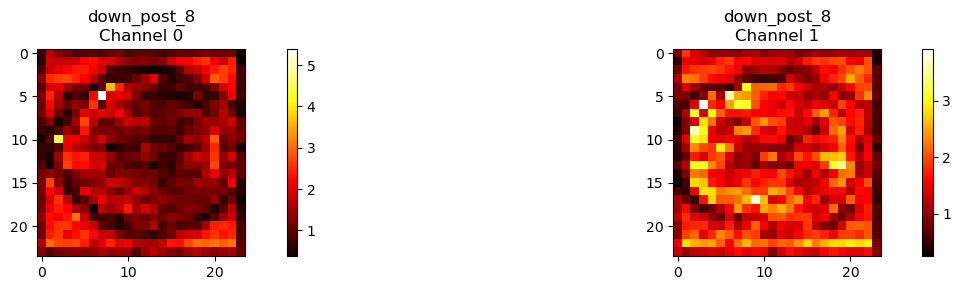

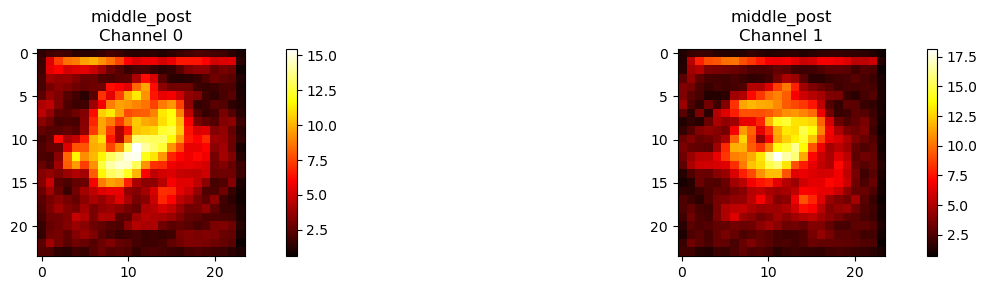

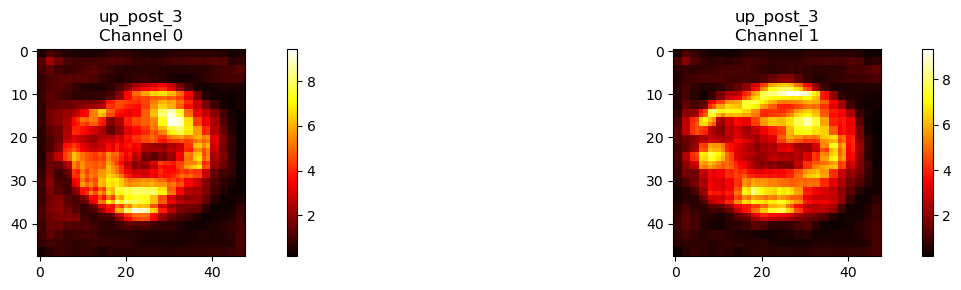

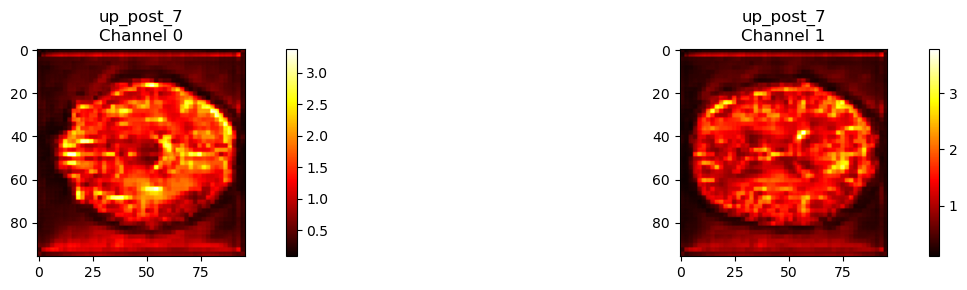

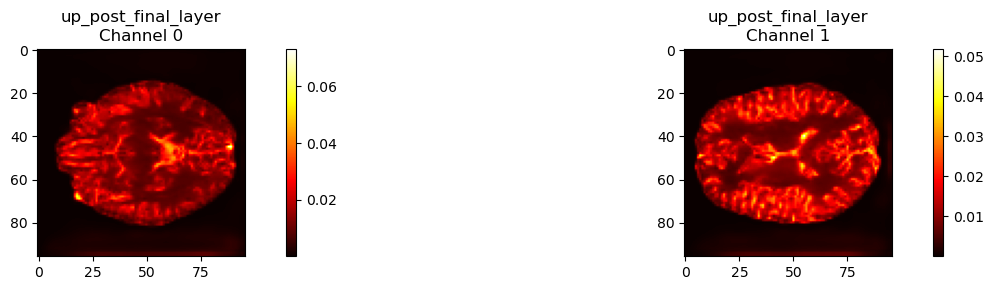

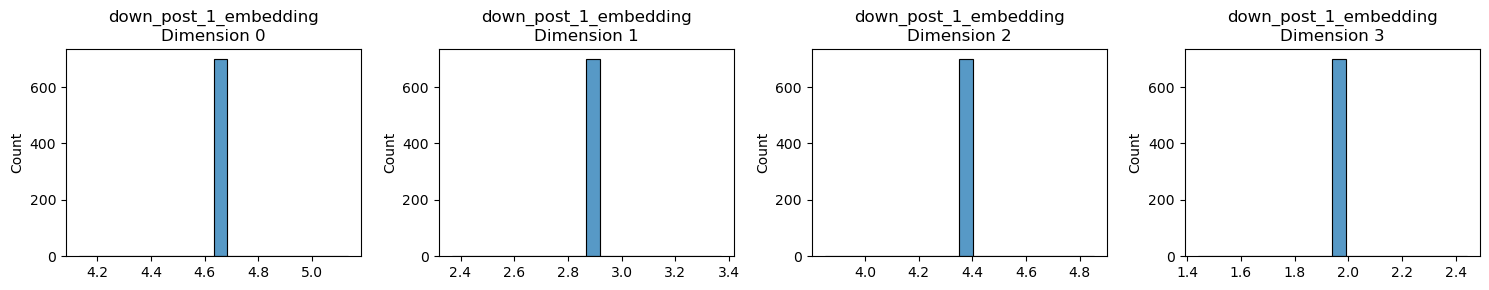

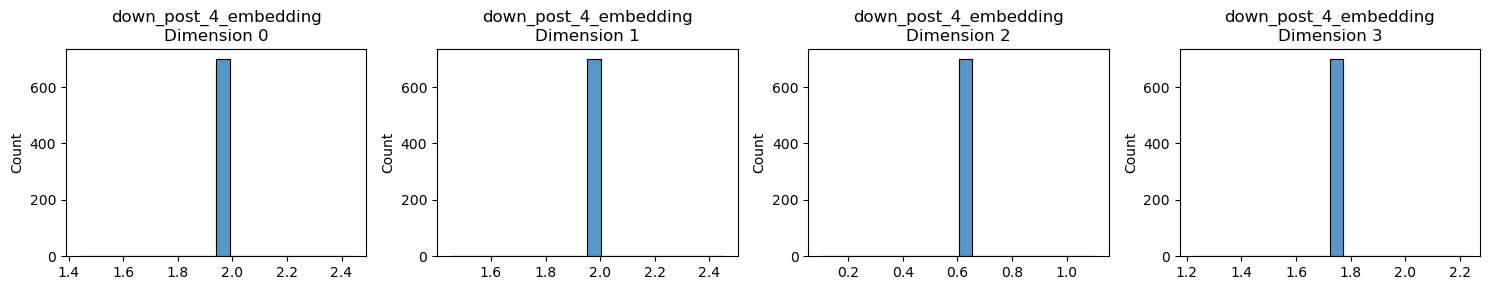

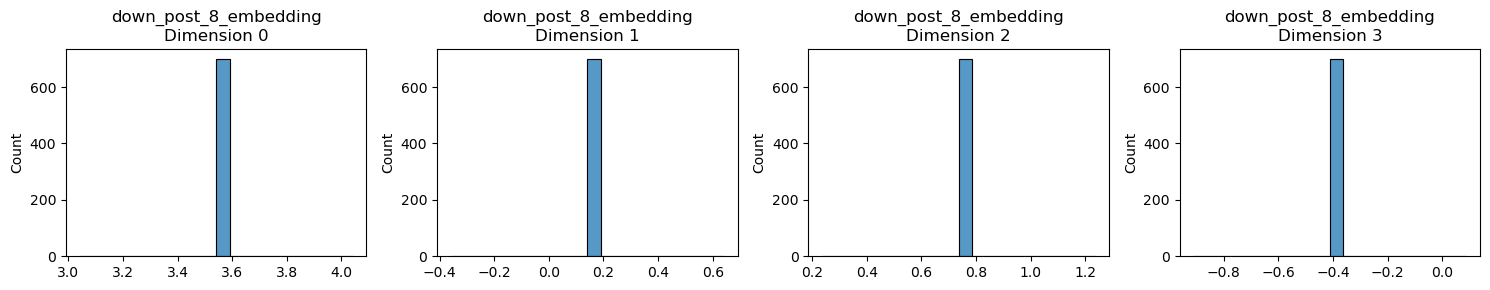

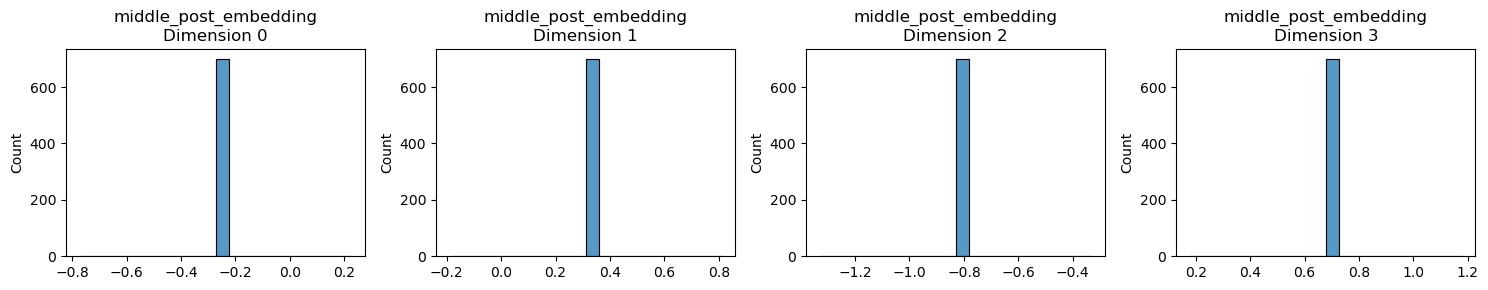

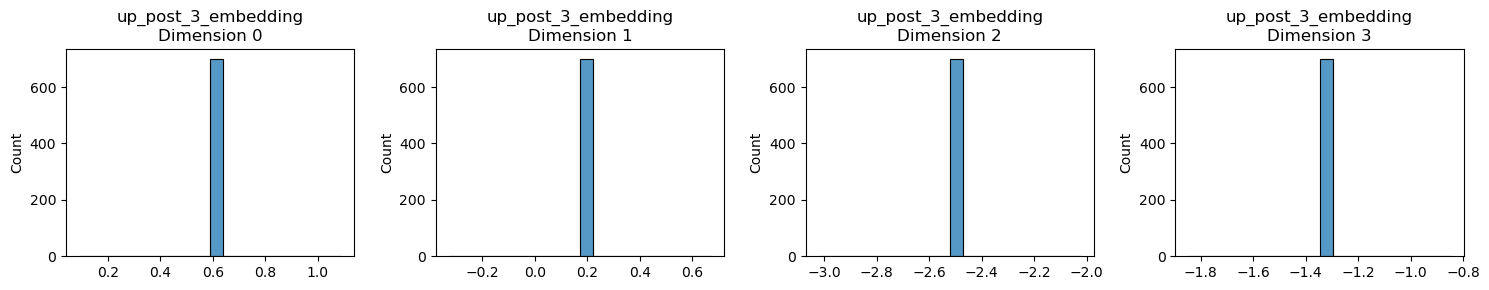

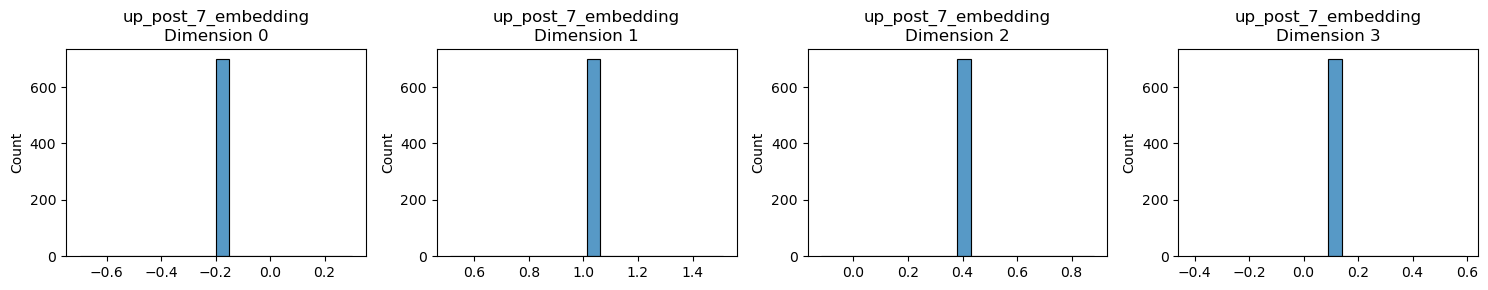

{'input': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'reconstruction': {'mean_variance': 0.0017927015433087945,
  'max_variance': 0.018300672993063927,
  'mean_cv': 0.2700928747653961,
  'variance_maps': tensor([[[5.0830e-05, 2.3890e-05, 2.2991e-05,  ..., 3.7487e-05,
            7.3753e-05, 4.2066e-05],
           [2.2444e-05, 2.2460e-05, 2.4861e-05,  ..., 5.5960e-05,
            6.5991e-05, 7.5540e-05],
           [1.7776e-05, 2.3676e-05, 3.4761e-05,  ..., 8.7111e-05,
            5.8547e-05, 5.401

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def check_input_consistency(data):
    """Verify that inputs are identical across runs"""
    input_var = torch.var(data['input'], dim=0)
    print(f"Mean input variance across runs: {input_var.mean():.10f}")
    return input_var

def analyze_reconstruction_consistency(data):
    """Analyze how reconstructions vary across runs"""
    # Calculate variance across runs for each pixel
    reco_var = torch.var(data['reconstructions'], dim=0)
    
    # Calculate coefficient of variation (CV = std/mean)
    reco_std = torch.std(data['reconstructions'], dim=0)
    reco_mean = torch.mean(data['reconstructions'], dim=0)
    cv = torch.where(reco_mean != 0, reco_std / reco_mean, torch.zeros_like(reco_std))
    
    metrics = {
        'mean_variance': reco_var.mean().item(),
        'max_variance': reco_var.max().item(),
        'mean_cv': cv.mean().item(),
        'variance_maps': reco_var,
        'cv_maps': cv
    }
    
    print("\nReconstruction Consistency Metrics:")
    print(f"Mean variance: {metrics['mean_variance']:.6f}")
    print(f"Max variance: {metrics['max_variance']:.6f}")
    print(f"Mean CV: {metrics['mean_cv']:.6f}")
    
    return metrics

def analyze_feature_consistency(data):
    """Analyze consistency of UNet feature maps across runs"""
    feature_metrics = {}
    
    for layer_name, feature_maps in data['features'].items():
        # Calculate variance across runs for each feature position
        variance = torch.var(feature_maps, dim=0)
        
        # Calculate mean variance for each feature channel
        channel_variance = variance.mean(dim=(1, 2))  # Average over spatial dimensions
        
        metrics = {
            'mean_variance': variance.mean().item(),
            'max_variance': variance.max().item(),
            'channel_variances': channel_variance,
            'variance_maps': variance
        }
        
        feature_metrics[layer_name] = metrics
        
        print(f"\n{layer_name} Feature Consistency:")
        print(f"Mean variance: {metrics['mean_variance']:.6f}")
        print(f"Max variance: {metrics['max_variance']:.6f}")
    
    return feature_metrics

def analyze_embedding_consistency(data):
    """Analyze consistency of embeddings across runs"""
    embedding_metrics = {}
    
    for emb_name, embeddings in data['embeddings'].items():
        # Calculate variance across runs for each embedding dimension
        variance = torch.var(embeddings, dim=0)
        
        metrics = {
            'mean_variance': variance.mean().item(),
            'max_variance': variance.max().item(),
            'dimension_variances': variance,
        }
        
        embedding_metrics[emb_name] = metrics
        
        print(f"\n{emb_name} Embedding Consistency:")
        print(f"Mean variance: {metrics['mean_variance']:.6f}")
        print(f"Max variance: {metrics['max_variance']:.6f}")
    
    return embedding_metrics

def plot_variance_maps(metrics, slice_idx=0):
    """Plot variance maps for reconstructions and feature maps"""
    # Plot reconstruction variance
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.imshow(metrics['reconstruction']['variance_maps'][slice_idx], cmap='hot')
    plt.colorbar()
    plt.title('Reconstruction Variance Map')
    
    plt.subplot(122)
    plt.imshow(metrics['reconstruction']['cv_maps'][slice_idx], cmap='hot')
    plt.colorbar()
    plt.title('Reconstruction CV Map')
    
    plt.tight_layout()
    plt.show()
    
    # Plot feature map variances
    for layer_name, layer_metrics in metrics['features'].items():
        variance_maps = layer_metrics['variance_maps']
        
        # Plot first few channels
        n_channels = min(4, variance_maps.shape[0])
        plt.figure(figsize=(15, 3))
        
        for i in range(n_channels):
            plt.subplot(1, n_channels, i+1)
            plt.imshow(variance_maps[i, slice_idx], cmap='hot')
            plt.colorbar()
            plt.title(f'{layer_name}\nChannel {i}')
        
        plt.tight_layout()
        plt.show()

def plot_embedding_distributions(data, slice_idx=0):
    """Plot distributions of embedding values across runs"""
    for emb_name, embeddings in data['embeddings'].items():
        # Select a few dimensions to plot
        n_dims = min(4, embeddings.shape[2])
        
        plt.figure(figsize=(15, 3))
        for i in range(n_dims):
            plt.subplot(1, n_dims, i+1)
            sns.histplot(embeddings[:, slice_idx, i].cpu().numpy(), bins=20)
            plt.title(f'{emb_name}\nDimension {i}')
        
        plt.tight_layout()
        plt.show()

# Usage
def analyze_consistency(data):
    metrics = {}
    
    # Check input consistency
    metrics['input'] = check_input_consistency(data)
    
    # Analyze reconstruction consistency
    metrics['reconstruction'] = analyze_reconstruction_consistency(data)
    
    # Analyze feature consistency
    metrics['features'] = analyze_feature_consistency(data)
    
    # Analyze embedding consistency
    metrics['embeddings'] = analyze_embedding_consistency(data)
    
    # Plot results
    plot_variance_maps(metrics)
    plot_embedding_distributions(data)
    
    return metrics

analyze_consistency(data)

Pixel (35,35) in slice 0:
Mean value: 0.9640
Variance: 0.0026
Standard deviation: 0.0511
Min value: 0.7988
Max value: 1.0596


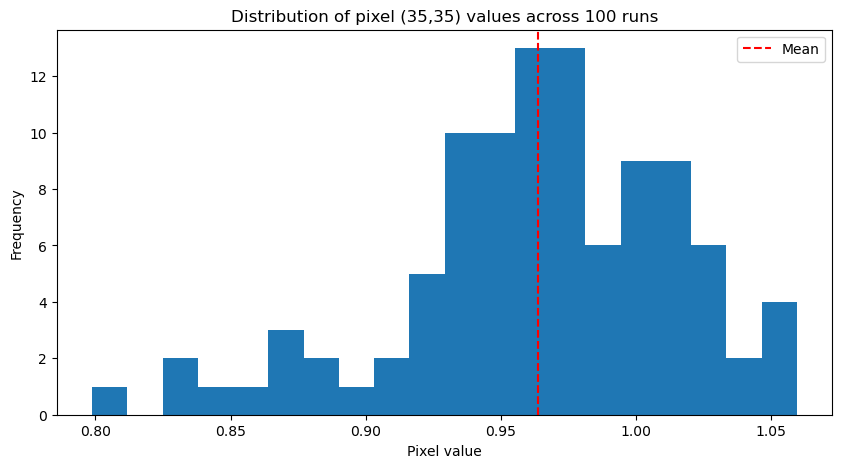

tensor([1.0332, 1.0371, 0.9531, 0.9585, 0.9468, 0.9512, 0.9565, 1.0391, 0.9688,
        0.9771, 0.9307, 1.0215, 0.9810, 1.0020, 0.9160, 0.8799, 0.9575, 0.9634,
        1.0234, 0.8389, 1.0107, 0.9619, 0.9551, 0.9604, 0.9341, 0.9854, 1.0049,
        1.0527, 0.8730, 0.9424, 0.9199, 0.9434, 1.0098, 0.9727, 0.9971, 0.9141,
        0.9590, 1.0049, 0.9902, 0.9795, 0.9839, 0.8682, 0.9370, 1.0039, 0.9229,
        0.8892, 0.9600, 0.9639, 1.0166, 1.0020, 0.9595, 0.9512, 0.9541, 0.9424,
        1.0234, 0.9775, 1.0186, 0.7988, 1.0156, 1.0039, 0.9541, 0.9678, 1.0488,
        1.0039, 0.9648, 0.8750, 0.9746, 1.0078, 0.9824, 0.9375, 0.9907, 0.9307,
        0.9404, 0.8633, 0.8975, 0.9917, 0.8374, 0.9229, 1.0469, 0.9990, 0.9727,
        0.9346, 0.9214, 0.9688, 0.9189, 0.9321, 0.9717, 1.0596, 1.0078, 0.9722,
        0.9351, 1.0098, 0.9785, 0.8359, 0.9307, 0.9746, 1.0273, 0.9668, 1.0195,
        1.0225])

In [ ]:
def examine_single_pixel(data, row=48, col=48, slice_idx=0):
    """Look at how one pixel varies across runs"""
    
    # Get all values for this pixel across runs
    pixel_values = data['reconstructions'][:, slice_idx, row, col]  # shape: (100)
    
    print(f"Pixel ({row},{col}) in slice {slice_idx}:")
    print(f"Mean value: {pixel_values.mean():.4f}")
    print(f"Variance: {pixel_values.var():.4f}")
    print(f"Standard deviation: {pixel_values.std():.4f}")
    print(f"Min value: {pixel_values.min():.4f}")
    print(f"Max value: {pixel_values.max():.4f}")
    
    # Plot distribution of values
    plt.figure(figsize=(10,5))
    plt.hist(pixel_values.cpu(), bins=20)
    plt.axvline(pixel_values.mean(), color='r', linestyle='--', label='Mean')
    plt.title(f'Distribution of pixel ({row},{col}) values across 100 runs')
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return pixel_values

examine_single_pixel(data, 35, 35)

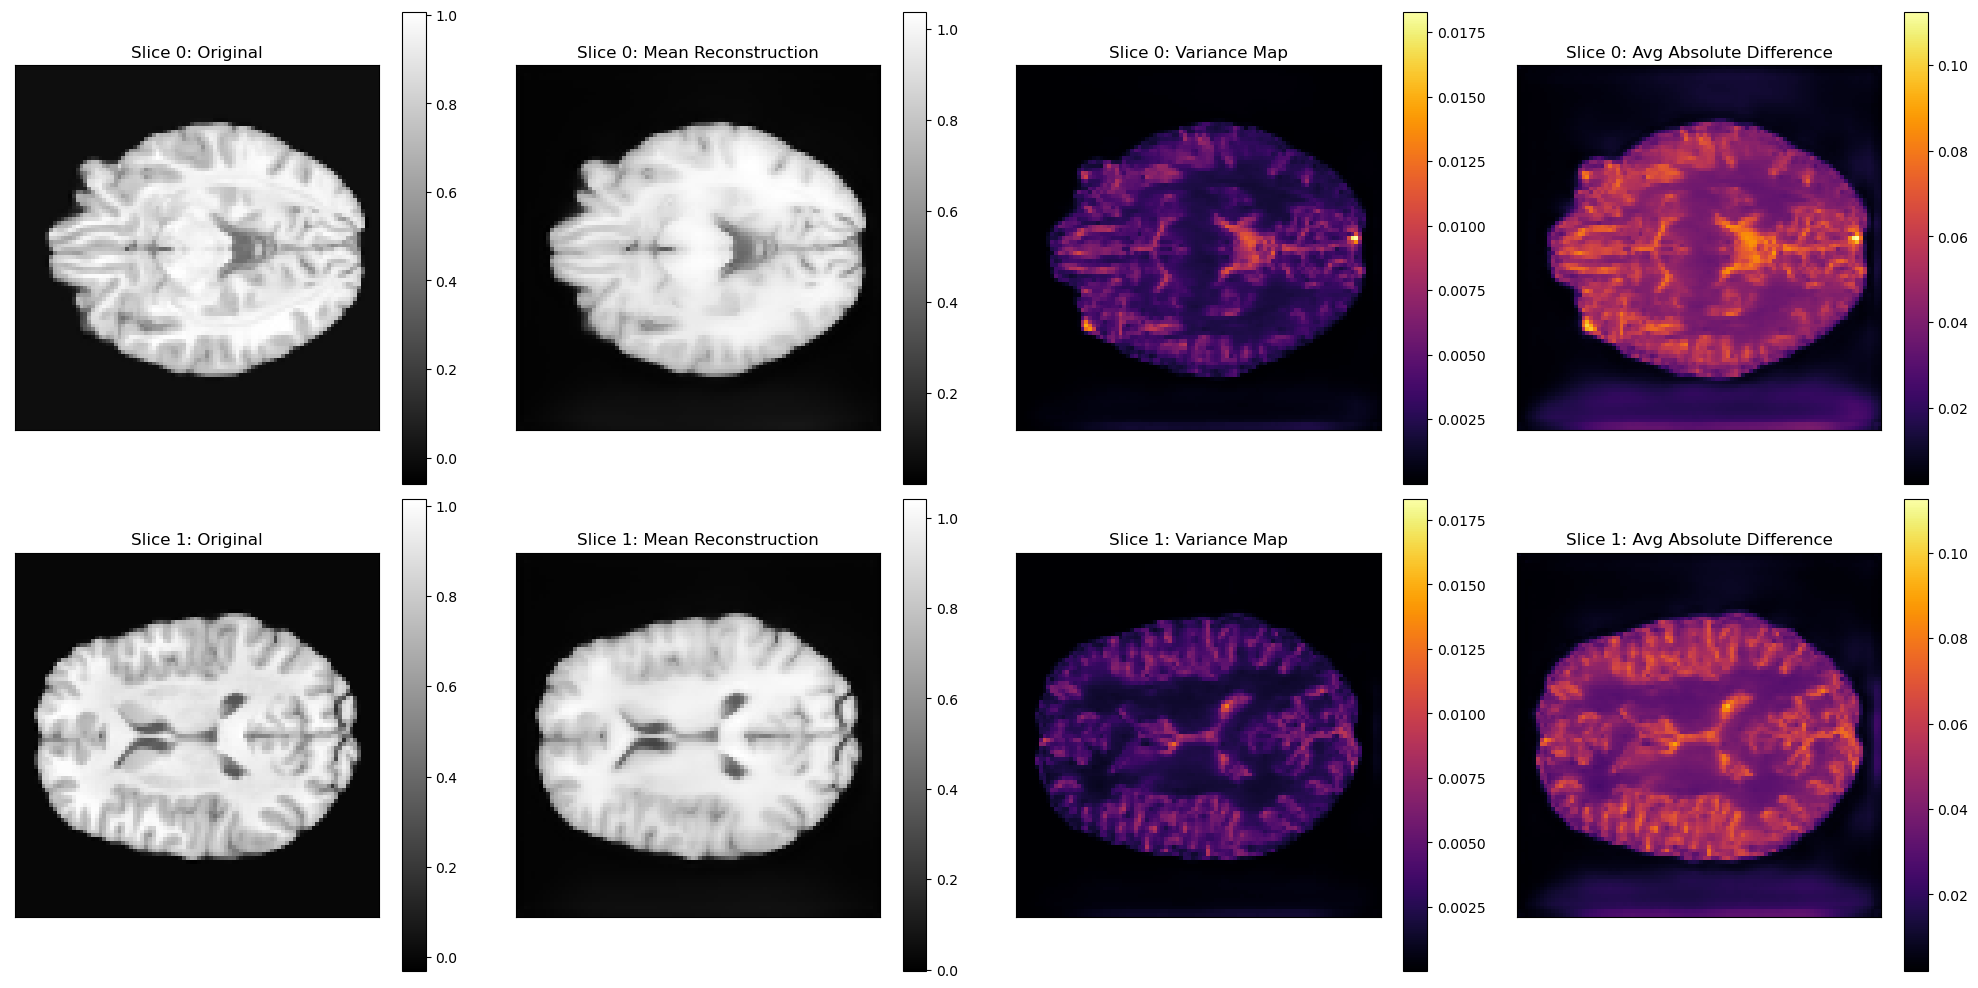


Slice-wise Statistics:

Slice 0:
Variance Map:
  Mean: 0.001882
  Max:  0.018301
  Min:  0.000008

Average Difference Map:
  Mean: 0.027628
  Max:  0.112554
  Min:  0.002236

Slice 1:
Variance Map:
  Mean: 0.001704
  Max:  0.012956
  Min:  0.000006

Average Difference Map:
  Mean: 0.026195
  Max:  0.094504
  Min:  0.001974


{'original_images': tensor([[[-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -6.5861e-44,
           -4.2039e-45, -0.0000e+00],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -8.5619e-43,
           -6.1657e-44, -2.8026e-45],
          [-0.0000e+00, -0.0000e+00, -5.6052e-45,  ..., -1.1931e-41,
           -8.5479e-43, -4.4842e-44],
          ...,
          [ 0.0000e+00,  1.4013e-45,  1.1210e-44,  ..., -9.3579e-42,
           -6.7122e-43, -3.5032e-44],
          [ 0.0000e+00,  0.0000e+00,  1.4013e-45,  ..., -6.7122e-43,
           -4.7644e-44, -2.8026e-45],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.5032e-44,
           -2.8026e-45, -0.0000e+00]],
 
         [[-0.0000e+00, -5.6052e-45, -8.8282e-44,  ..., -0.0000e+00,
           -0.0000e+00, -0.0000e+00],
          [-5.6052e-45, -8.1275e-44, -1.1421e-42,  ..., -4.2039e-45,
           -0.0000e+00, -0.0000e+00],
          [-8.8282e-44, -1.1421e-42, -1.5901e-41,  ..., -6.1657e-44,
           -4.2039e-45, -0.0000e+00],


In [50]:
def analyze_reconstruction_differences_all_slices(data):
    """
    Calculate and visualize average pixel-wise differences between reconstructions
    for all slices, including original images for comparison.
    
    Args:
        data: Dictionary containing:
            - 'reconstructions' tensor of shape [n_runs, n_slices, H, W]
            - 'input' tensor of shape [n_runs, n_slices, H, W]
    """
    recons = data['reconstructions']  # Shape: [n_runs, n_slices, H, W]
    originals = data['input']  # Shape: [n_runs, n_slices, H, W]
    n_slices = recons.shape[1]
    
    # Take first run's input as original (they should all be the same)
    original_images = originals[0]  # Shape: [n_slices, H, W]
    
    # Calculate maps for all slices
    variance_maps = torch.var(recons, dim=0)  # Shape: [n_slices, H, W]
    mean_recons = torch.mean(recons, dim=0)   # Shape: [n_slices, H, W]
    avg_diff_maps = torch.mean(torch.abs(recons - mean_recons.unsqueeze(0)), dim=0)  # Shape: [n_slices, H, W]
    
    # Create visualization with 4 columns
    fig, axes = plt.subplots(n_slices, 4, figsize=(20, 5*n_slices))
    
    # In case of single slice, make axes 2D
    if n_slices == 1:
        axes = axes[np.newaxis, :]
    
    # Get global min/max for consistent colorbars
    var_vmax = variance_maps.max().item()
    diff_vmax = avg_diff_maps.max().item()
    
    for slice_idx in range(n_slices):
        # Plot original image
        im0 = axes[slice_idx, 0].imshow(original_images[slice_idx].cpu(), cmap='gray')
        axes[slice_idx, 0].set_title(f'Slice {slice_idx}: Original')
        plt.colorbar(im0, ax=axes[slice_idx, 0])
        
        # Plot mean reconstruction
        im1 = axes[slice_idx, 1].imshow(mean_recons[slice_idx].cpu(), cmap='gray')
        axes[slice_idx, 1].set_title(f'Slice {slice_idx}: Mean Reconstruction')
        plt.colorbar(im1, ax=axes[slice_idx, 1])
        
        # Plot variance map
        im2 = axes[slice_idx, 2].imshow(variance_maps[slice_idx].cpu(), cmap='inferno', vmax=var_vmax)
        axes[slice_idx, 2].set_title(f'Slice {slice_idx}: Variance Map')
        plt.colorbar(im2, ax=axes[slice_idx, 2])
        
        # Plot average difference map
        im3 = axes[slice_idx, 3].imshow(avg_diff_maps[slice_idx].cpu(), cmap='inferno', vmax=diff_vmax)
        axes[slice_idx, 3].set_title(f'Slice {slice_idx}: Avg Absolute Difference')
        plt.colorbar(im3, ax=axes[slice_idx, 3])
        
        # Remove ticks for cleaner visualization
        for ax in axes[slice_idx]:
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for each slice
    print("\nSlice-wise Statistics:")
    for slice_idx in range(n_slices):
        print(f"\nSlice {slice_idx}:")
        print("Variance Map:")
        print(f"  Mean: {torch.mean(variance_maps[slice_idx]):.6f}")
        print(f"  Max:  {torch.max(variance_maps[slice_idx]):.6f}")
        print(f"  Min:  {torch.min(variance_maps[slice_idx]):.6f}")
        print("\nAverage Difference Map:")
        print(f"  Mean: {torch.mean(avg_diff_maps[slice_idx]):.6f}")
        print(f"  Max:  {torch.max(avg_diff_maps[slice_idx]):.6f}")
        print(f"  Min:  {torch.min(avg_diff_maps[slice_idx]):.6f}")
    
    return {
        'original_images': original_images,
        'mean_reconstructions': mean_recons,
        'variance_maps': variance_maps,
        'avg_difference_maps': avg_diff_maps
    }
analyze_reconstruction_differences_all_slices(data)